<a href="https://colab.research.google.com/github/ParsecInstitute/Tutorials/blob/main/deeplearning_basics/FlowerDenoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import PIL
from tqdm import tqdm
import numpy as np

In [2]:
def flower_grid(ds):
  fig, axs = plt.subplots(10, 10, figsize=(20, 20))
  for image, _ in ds.take(1): # take a single batch
    for i in range(10):
      for j in range(10):
        k = i * 10 + j
        axs[i, j].imshow((image[k] * 255.).numpy().astype("uint8"))
        axs[i, j].axis("off")
  plt.subplots_adjust(wspace=0, hspace=-0.1)

# Download the Dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 5s 0us/step


# Preprocess images

We skip most preprocessing step by using tensorflow dataset. Otherwise, they include transforming png files in float32 arrays and reshaping all image 
to a standardized (128, 128, 3) shape. We also split the dataset into a training set and a validation set.

In [4]:
batch_size = 128
img_height = 128
img_width = 128

def normalize(x, y):
    return tf.cast(x, tf.float32) / 255., y

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size).map(normalize)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size).map(normalize)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


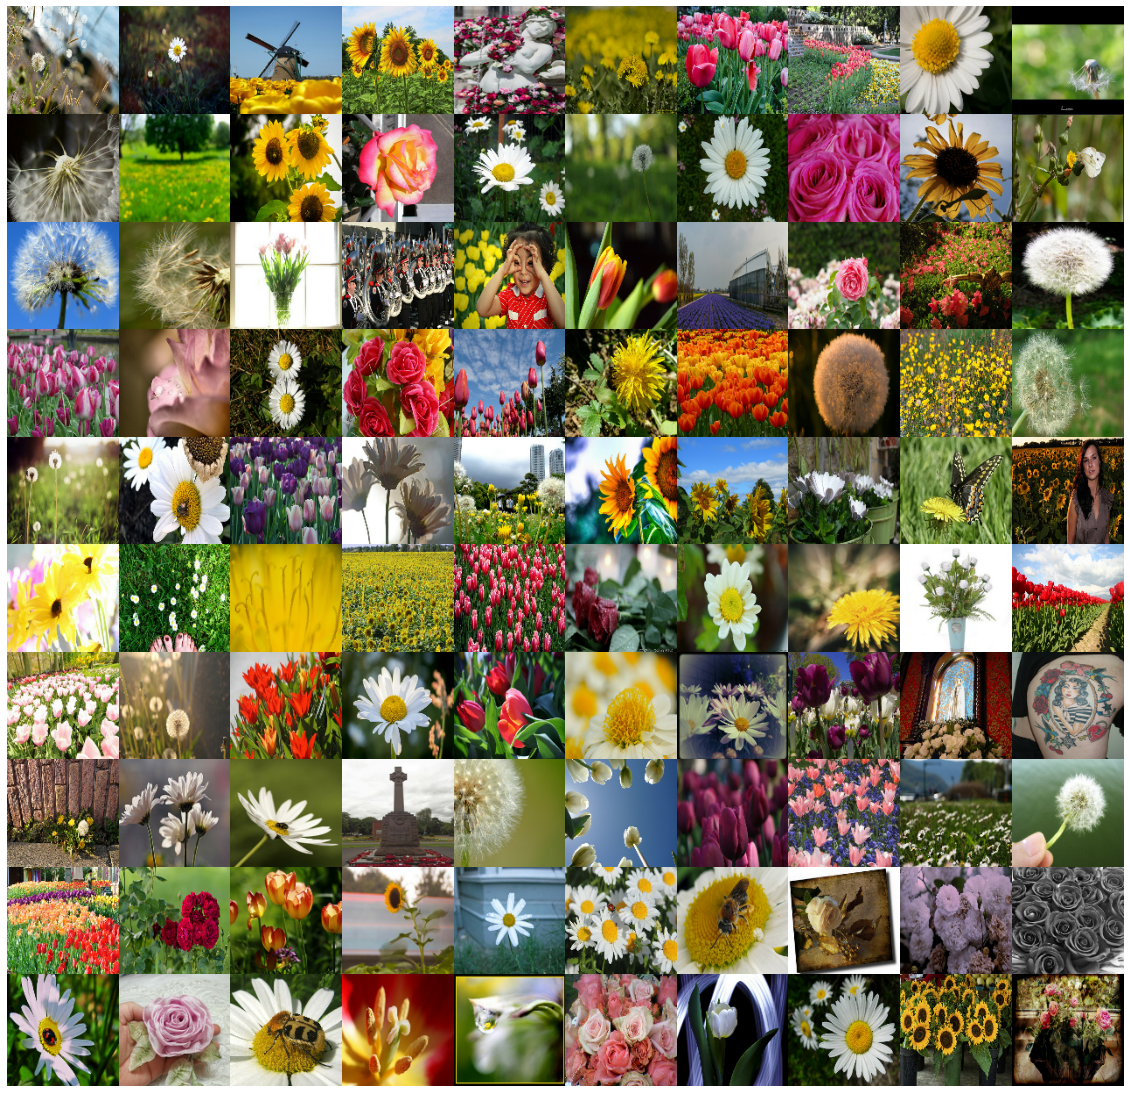

In [6]:
flower_grid(train_ds)

# Denoising problem

We wish to recover $\mathbf{x}$ given $\mathbf{y}$:
$$
  \mathbf{y} = \mathbf{x} + \boldsymbol{\eta}
$$
where $\boldsymbol{\eta} \sim \mathcal{N}(0, \sigma^2)$.

To do this, we use an hourglass CNN architecture. The idea is to use the information bottleneck and the spectral bias of the hourglass architecture to remove high frequency noise and retrieve $\mathbf{x}$.

The loss function is a mean squared error.

In [7]:
# Define the model

model = tf.keras.Sequential(
    [
     # Encoding part
     tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
    #  tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"), # make deeper to remove even more high frequencies
     # Decoding part
    #  tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation="relu", padding="same"),
     tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="same"), # no activation here to avoid vanishing gradient problems in deeper layer
    ]
)

model.build([None, img_height, img_width, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          2320      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 16)       2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 16)       2320      
 ranspose)                                              

In [8]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [9]:
# Custom optimization loop
epochs = 25
sigma = 0.1 # noise level

history = {
    "Cost": [],
    "Val Cost": []
}
cost = tf.metrics.Mean() # expectation of the loss function over an epoch
val_cost = tf.metrics.Mean() # expectation of the loss over the validation set
pbar = tqdm(range(epochs))
for epoch in pbar:
    # training
    cost.reset_states()
    for x, _ in train_ds:
        with tf.GradientTape() as tape: # Start tape recording for gradient computation
            tape.watch(model.trainable_variables) # Take the derivative w.r.t model parameters
            y = x + tf.random.normal(shape=x.shape, stddev=sigma) # y = x + eta
            x_pred = model(y) # model prediction
            batch_cost = tf.reduce_mean((x - x_pred)**2) # loss function
        gradient = tape.gradient(batch_cost, model.trainable_variables) # compute gradient
        gradient = [tf.clip_by_norm(g, 5.) for g in gradient] # gradient clipping
        optimizer.apply_gradients(zip(gradient, model.trainable_variables)) # backpropagation
        cost.update_state([batch_cost])
        pbar.set_description("Cost %.2e, Val Cost %.2e" % (cost.result().numpy(), val_cost.result().numpy()))
  
    # Validation
    val_cost.reset_states()
    for x, _ in val_ds:
        y = x + tf.random.normal(shape=x.shape, stddev=sigma) # y = x + eta
        x_pred = model(y) # model prediction
        batch_cost = tf.reduce_mean((x - x_pred)**2) # loss function
        val_cost.update_state([batch_cost])
    pbar.set_description("Cost %.2e, Val Cost %.2e" % (cost.result().numpy(), val_cost.result().numpy()))

    # Logs
    print(f"epoch {epoch} | train cost {cost.result().numpy():.2e} | val cost {val_cost.result().numpy():.2e}")
    history["Cost"].append(cost.result().numpy())
    history["Val Cost"].append(val_cost.result().numpy())

Cost 1.91e-01, Val Cost 1.20e-01:   4%|▍         | 1/25 [00:38<15:18, 38.28s/it]

epoch 0 | train cost 1.91e-01 | val cost 1.20e-01


Cost 8.43e-02, Val Cost 5.83e-02:   8%|▊         | 2/25 [01:16<14:33, 37.96s/it]

epoch 1 | train cost 8.43e-02 | val cost 5.83e-02


Cost 5.02e-02, Val Cost 4.30e-02:  12%|█▏        | 3/25 [01:55<14:06, 38.49s/it]

epoch 2 | train cost 5.02e-02 | val cost 4.30e-02


Cost 4.14e-02, Val Cost 3.84e-02:  16%|█▌        | 4/25 [02:40<14:21, 41.01s/it]

epoch 3 | train cost 4.14e-02 | val cost 3.84e-02


Cost 3.84e-02, Val Cost 3.65e-02:  20%|██        | 5/25 [03:26<14:16, 42.84s/it]

epoch 4 | train cost 3.84e-02 | val cost 3.65e-02


Cost 3.66e-02, Val Cost 3.48e-02:  24%|██▍       | 6/25 [04:02<12:51, 40.61s/it]

epoch 5 | train cost 3.66e-02 | val cost 3.48e-02


Cost 3.49e-02, Val Cost 3.31e-02:  28%|██▊       | 7/25 [04:48<12:43, 42.40s/it]

epoch 6 | train cost 3.49e-02 | val cost 3.31e-02


Cost 3.35e-02, Val Cost 3.17e-02:  32%|███▏      | 8/25 [05:33<12:14, 43.21s/it]

epoch 7 | train cost 3.35e-02 | val cost 3.17e-02


Cost 3.24e-02, Val Cost 3.10e-02:  36%|███▌      | 9/25 [06:09<10:56, 41.02s/it]

epoch 8 | train cost 3.24e-02 | val cost 3.10e-02


Cost 3.17e-02, Val Cost 3.03e-02:  40%|████      | 10/25 [06:54<10:33, 42.23s/it]

epoch 9 | train cost 3.17e-02 | val cost 3.03e-02


Cost 3.11e-02, Val Cost 2.98e-02:  44%|████▍     | 11/25 [07:40<10:07, 43.41s/it]

epoch 10 | train cost 3.11e-02 | val cost 2.98e-02


Cost 3.06e-02, Val Cost 2.93e-02:  48%|████▊     | 12/25 [08:17<08:56, 41.29s/it]

epoch 11 | train cost 3.06e-02 | val cost 2.93e-02


Cost 3.03e-02, Val Cost 2.90e-02:  52%|█████▏    | 13/25 [09:03<08:32, 42.74s/it]

epoch 12 | train cost 3.03e-02 | val cost 2.90e-02


Cost 2.99e-02, Val Cost 2.87e-02:  56%|█████▌    | 14/25 [09:48<07:57, 43.45s/it]

epoch 13 | train cost 2.99e-02 | val cost 2.87e-02


Cost 2.94e-02, Val Cost 2.82e-02:  60%|██████    | 15/25 [10:33<07:19, 43.91s/it]

epoch 14 | train cost 2.94e-02 | val cost 2.82e-02


Cost 2.90e-02, Val Cost 2.78e-02:  64%|██████▍   | 16/25 [11:11<06:19, 42.15s/it]

epoch 15 | train cost 2.90e-02 | val cost 2.78e-02


Cost 2.87e-02, Val Cost 2.74e-02:  68%|██████▊   | 17/25 [11:56<05:44, 43.05s/it]

epoch 16 | train cost 2.87e-02 | val cost 2.74e-02


Cost 2.83e-02, Val Cost 2.72e-02:  72%|███████▏  | 18/25 [12:42<05:07, 43.96s/it]

epoch 17 | train cost 2.83e-02 | val cost 2.72e-02


Cost 2.80e-02, Val Cost 2.73e-02:  76%|███████▌  | 19/25 [13:28<04:27, 44.60s/it]

epoch 18 | train cost 2.80e-02 | val cost 2.73e-02


Cost 2.77e-02, Val Cost 2.65e-02:  80%|████████  | 20/25 [14:13<03:43, 44.75s/it]

epoch 19 | train cost 2.77e-02 | val cost 2.65e-02


Cost 2.74e-02, Val Cost 2.65e-02:  84%|████████▍ | 21/25 [14:58<02:59, 44.83s/it]

epoch 20 | train cost 2.74e-02 | val cost 2.65e-02


Cost 2.71e-02, Val Cost 2.58e-02:  88%|████████▊ | 22/25 [15:35<02:07, 42.34s/it]

epoch 21 | train cost 2.71e-02 | val cost 2.58e-02


Cost 2.65e-02, Val Cost 2.54e-02:  92%|█████████▏| 23/25 [16:21<01:26, 43.47s/it]

epoch 22 | train cost 2.65e-02 | val cost 2.54e-02


Cost 2.37e-02, Val Cost 2.15e-02:  96%|█████████▌| 24/25 [16:58<00:41, 41.55s/it]

epoch 23 | train cost 2.37e-02 | val cost 2.15e-02


Cost 2.15e-02, Val Cost 2.01e-02: 100%|██████████| 25/25 [17:35<00:00, 42.24s/it]

epoch 24 | train cost 2.15e-02 | val cost 2.01e-02


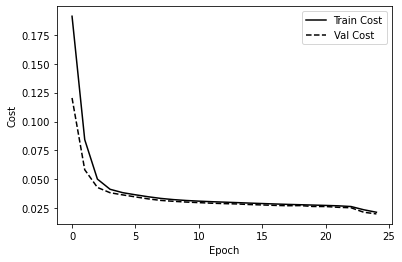

In [10]:
plt.plot(history["Cost"], "k-", label="Train Cost")
plt.plot(history["Val Cost"], "k--", label="Val Cost")
plt.ylabel("Cost")
plt.xlabel("Epoch")
plt.legend()

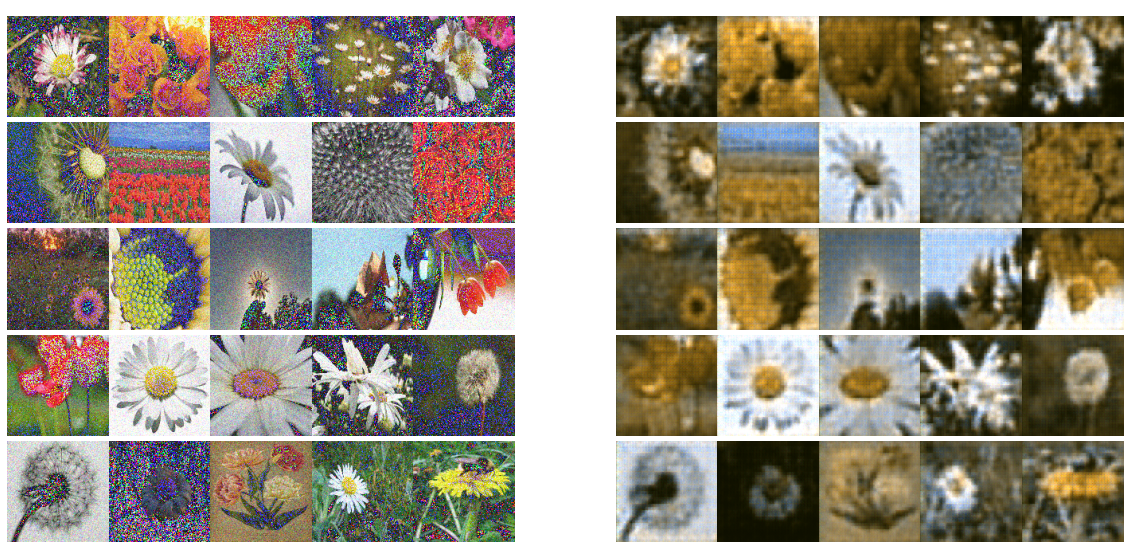

In [14]:
# Show result on validation set (input on the left, output on the right)

fig, axs = plt.subplots(5, 11, figsize=(20, 10))
for x, _ in val_ds.take(1): # take a single batch
  y = x + tf.random.normal(shape=x.shape, stddev=sigma) # y = x + eta
  x_pred = tf.nn.relu(model(y))
  for i in range(5):
    for j in range(5):
      k = i * 5 + j
      axs[i, j].imshow(np.minimum((y[k] * 255.).numpy(), 255).astype("uint8"))
      axs[i, j].axis("off")
      axs[i, j+6].imshow(np.minimum((x_pred[k] * 255.).numpy(), 255).astype("uint8"))
      axs[i, j+6].axis("off")
    axs[i, 5].axis("off")
plt.subplots_adjust(wspace=0, hspace=-0.1)